In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

In [50]:
ocde_data = pd.read_csv('data/DNK.csv',
                        index_col='TIME',
                        dtype={'Value': np.float64},
                       usecols = ['TIME', 'Value'],
                       parse_dates=True, 
                      date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m'))

<ipython-input-50-4130e3a2c3a8>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m'))


In [51]:
ocde_data.head()

,Value
TIME,
1999-11-01,3.8526
1999-12-01,3.7988
2000-01-01,3.7165
2000-02-01,3.9332
2000-03-01,4.1848


In [52]:
# create a time series
s = pd.Series(ocde_data.unstack().values, index=ocde_data.index)

<AxesSubplot:xlabel='TIME'>

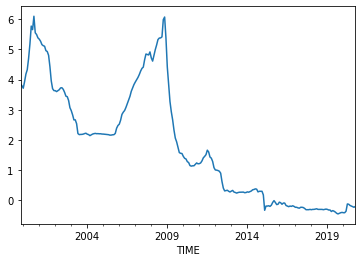

In [53]:
s.plot()

In [54]:
# calculate descriptive statistics
s.describe()

count    252.000000
mean       1.835286
std        1.928916
min       -0.450000
25%       -0.090000
50%        1.457850
75%        3.483975
max        6.101700
dtype: float64

In [55]:
df = pd.DataFrame()
df['year'] = [s.index[i].year for i in range(len(s))]
df['month'] = [s.index[i].month for i in range(len(s))]
df['value'] = s.values.tolist()

In [56]:
df.head()

,year,month,value
0,1999,11,3.8526
1,1999,12,3.7988
2,2000,1,3.7165
3,2000,2,3.9332
4,2000,3,4.1848


In [57]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [58]:
df.head()

,t,t+1
0,NaN,3.8526
1,3.8526,3.7988
2,3.7988,3.7165
3,3.7165,3.9332
4,3.9332,4.1848


In [59]:
#sliding window method
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
df.columns = ['t-2', 't-1', 't', 't+1']

In [60]:
df.head()

,t-2,t-1,t,t+1
0,NaN,NaN,NaN,3.8526
1,NaN,NaN,3.8526,3.7988
2,NaN,3.8526,3.7988,3.7165
3,3.8526,3.7988,3.7165,3.9332
4,3.7988,3.7165,3.9332,4.1848


In [61]:
values = pd.DataFrame(s.values)
width = 3
shifted = values.shift(width - 1)
window = shifted.rolling(window=width)

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']

In [62]:
df.head()

,min,mean,max,t+1
0,NaN,NaN,NaN,3.8526
1,NaN,NaN,NaN,3.7988
2,NaN,NaN,NaN,3.7165
3,NaN,NaN,NaN,3.9332
4,3.7165,3.7893,3.8526,4.1848


<AxesSubplot:ylabel='Density'>

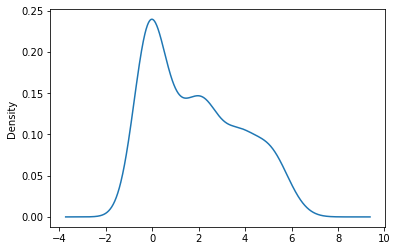

In [63]:
s.plot(kind='kde')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

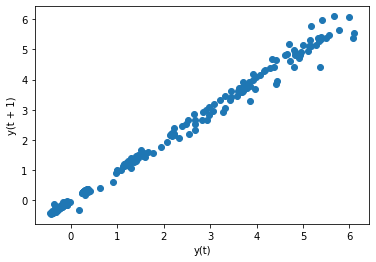

In [64]:
# create a scatter plot
lag_plot(s)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

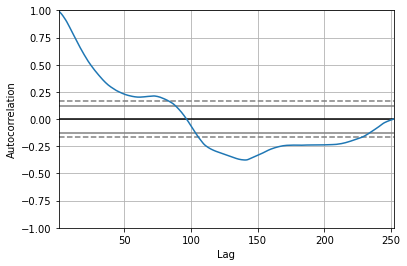

In [65]:
# create an autocorrelation plot
autocorrelation_plot(s)

# Autoregression model

In [66]:
# tail-rolling average transform
rolling = s.rolling(window=3)
rolling_mean = rolling.mean()

In [67]:
#Moving average as prediction
# prepare problem
X = s.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [68]:
print('RMSE: %.3f' % rmse)

RMSE: 0.266


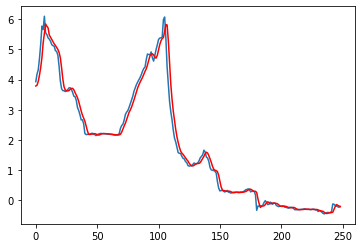

In [69]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [70]:
# calculate stationarity test of time series data
X = s.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.423067
p-value: 0.571169
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


--> cannot reject null hypothesis : data not stationary


In [48]:
s.apply(np.log)

TIME
1999-11-01    1.348748
1999-12-01    1.334685
2000-01-01    1.312782
2000-02-01    1.369453
2000-03-01    1.431459
                ...   
2020-06-01         NaN
2020-07-01         NaN
2020-08-01         NaN
2020-09-01         NaN
2020-10-01         NaN
Length: 252, dtype: float64

In [71]:
# split dataset
X = s.values
train_size = int(len(X) * 0.80)
train, test = X[1:train_size], X[train_size:]

Observations: 126
Training Observations: 63
Testing Observations: 63
-----
Observations: 189
Training Observations: 126
Testing Observations: 63
-----
Observations: 252
Training Observations: 189
Testing Observations: 63
-----


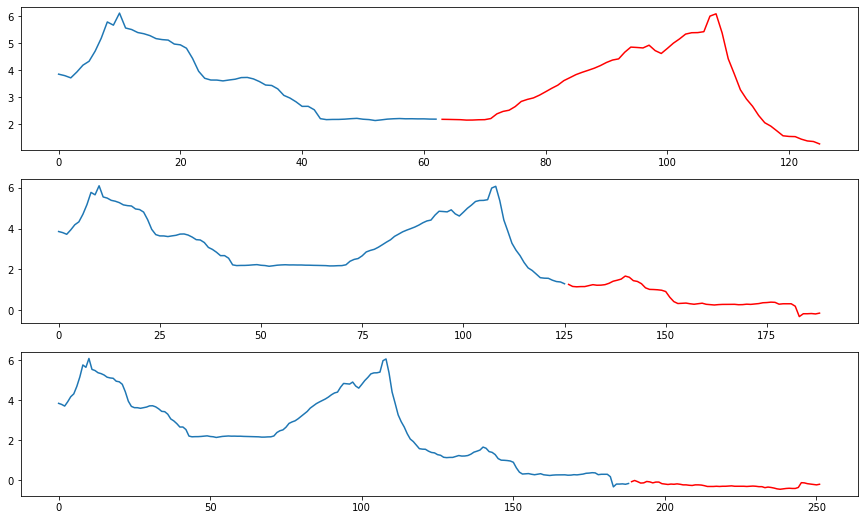

In [77]:

# calculate repeated train-test splits of time series data
X = s.values
splits = TimeSeriesSplit(n_splits=3)
index = 1
plt.figure(1, figsize=(15,9))

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))

    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test], color='r')
    index += 1
plt.show() 

In [72]:
# train autoregression
model = AR(train)
model_fit = model.fit()

/home/ckennedy/.local/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarni

In [78]:

# walk forward validation: the train set expanding each time step and the test set fixed at one time step ahead
X = s[-100:].values
n_train = 80
n_records = len(X)

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

train=80, test=1
train=81, test=1
train=82, test=1
train=83, test=1
train=84, test=1
train=85, test=1
train=86, test=1
train=87, test=1
train=88, test=1
train=89, test=1
train=90, test=1
train=91, test=1
train=92, test=1
train=93, test=1
train=94, test=1
train=95, test=1
train=96, test=1
train=97, test=1
train=98, test=1
train=99, test=1


In [73]:
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 14
Coefficients: [ 1.41353654e-02  1.77115606e+00 -1.07899246e+00  5.03977804e-01
 -2.16456387e-01 -3.44416241e-04  7.53076356e-02 -6.94736285e-02
 -4.58936167e-02  1.41354874e-03  1.66182439e-01 -1.54610918e-01
  4.51046257e-02  2.36692316e-02 -3.09741347e-02]


In [74]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)